In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer

# Load the EuroBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('../models/eurobert')

In [2]:
try:
    df = pd.read_csv('../data/interim/cleaned.csv')
    print(f"Datensatz geladen mit {len(df)} Zeilen")
    print(f"Verfügbare Spalten: {df.columns.tolist()}")
except Exception as e:
    print("Fehler beim Laden des Datensatzes:")
    print(e)

Datensatz geladen mit 6432 Zeilen
Verfügbare Spalten: ['id', 'date', 'summary', 'judgement', 'subset_name', 'split_name', 'is_announcement_rule', 'matching_criteria']


In [3]:
# Datenstruktur anzeigen
print(df.head())
print(df.columns)

          id        date                                            summary  \
0   bag_1-17  18.01.2017  18.01.2017\n1/17 - Betriebsratstätigkeit - Arb...   
1   bag_1-19  22.01.2019  22.01.2019\n1/19 - Urlaubsabgeltung bei Tod de...   
2  bag_10-19  20.02.2019  20.02.2019\n10/19 - Kündigung des Chefarztes e...   
3  bag_11-18  22.02.2018  22.02.2018\n11/18 - Annahmeverzugsvergütung al...   
4  bag_11-20  27.02.2020  27.02.2020\n11/20 - Kündigungen des Cockpit-Pe...   

                                           judgement           subset_name  \
0  Tenor\n\n\n\n\nAuf die Revision der Beklagten ...  Bundesarbeitsgericht   
1  Tenor\n\n\n\n\n1. Die Revision der Beklagten g...  Bundesarbeitsgericht   
2  Tenor\n\n\n\n\nDie Revision der Beklagten gege...  Bundesarbeitsgericht   
3  Tenor\n\n\n\n\n1. Die Revision des Beklagten g...  Bundesarbeitsgericht   
4  Tenor\n\n\n\n\nAuf die Revision des Klägers wi...  Bundesarbeitsgericht   

  split_name  is_announcement_rule  matching_criteria  


## Exploration

In [4]:
# Überprüfe die Aufteilung des Datensatzes in Train/Val/Test
def analyze_splits(df):
    # Calculate split ratios using split_name column
    split_counts = df['split_name'].value_counts()
    total = len(df)
    
    print('Dataset Split Analysis:')
    print('-' * 30)
    for split, count in split_counts.items():
        percentage = (count / total) * 100
        print(f'{split}: {count} samples ({percentage:.2f}%)')

# Analyze splits if dataset is loaded
if 'df' in globals():
    analyze_splits(df)
else:
    print('Dataset not loaded successfully')

Dataset Split Analysis:
------------------------------
train: 4643 samples (72.19%)
test: 1045 samples (16.25%)
validation: 744 samples (11.57%)


In [5]:
# Länge der Zusammenfassung und des Urteils in BPE Tokens berechnen
df['summary_length'] = df['summary'].apply(lambda x: len(tokenizer.encode(x)))
df['judgement_length'] = df['judgement'].apply(lambda x: len(tokenizer.encode(x)))
print('Summary and Judgement Lengths in BPE tokens:')
print(df[['summary_length', 'judgement_length']].describe())

Summary and Judgement Lengths in BPE tokens:
       summary_length  judgement_length
count     6432.000000       6432.000000
mean      1402.323072      10809.584266
std        954.523217      10739.268788
min        122.000000        323.000000
25%        819.000000       5195.500000
50%       1133.000000       8065.000000
75%       1654.000000      12595.250000
max      11739.000000     225333.000000



Verteilung der Fälle nach Jahr:


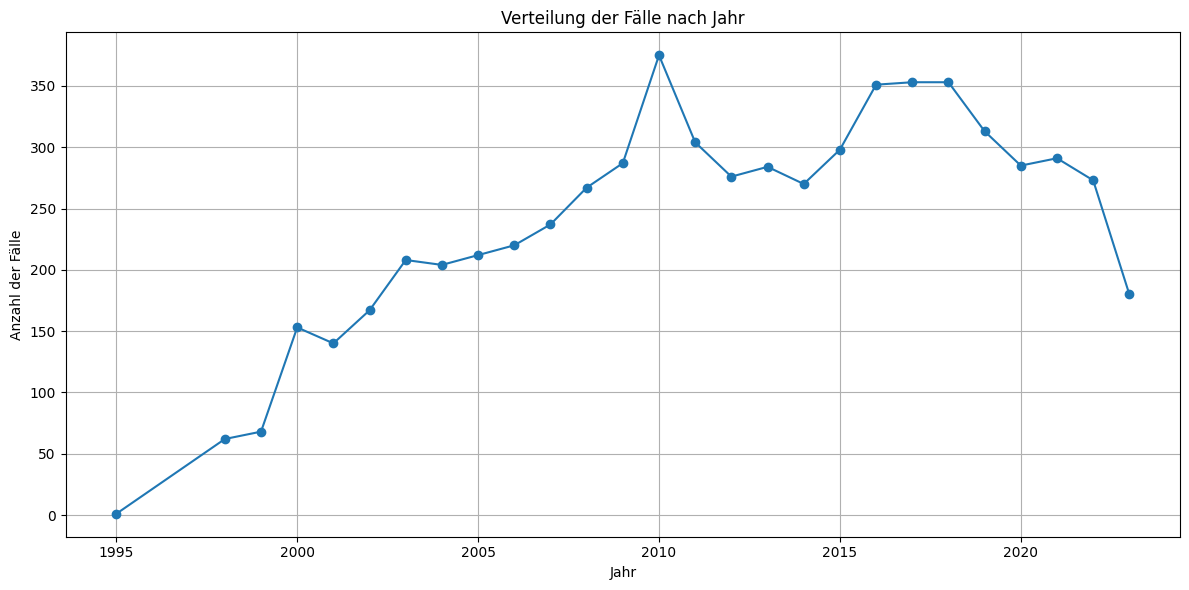

In [6]:
# Verteilung nach Jahren ansehen
df['year'] = df['date'].str.extract(r'(\d{4})').astype(int)
year_counts = df['year'].value_counts().sort_index()
print("\nVerteilung der Fälle nach Jahr:")
# print(year_counts) 
plt.figure(figsize=(12, 6))
year_counts.plot(kind='line', marker='o')
plt.title('Verteilung der Fälle nach Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Fälle')
plt.grid(True)
plt.tight_layout()
plt.show()

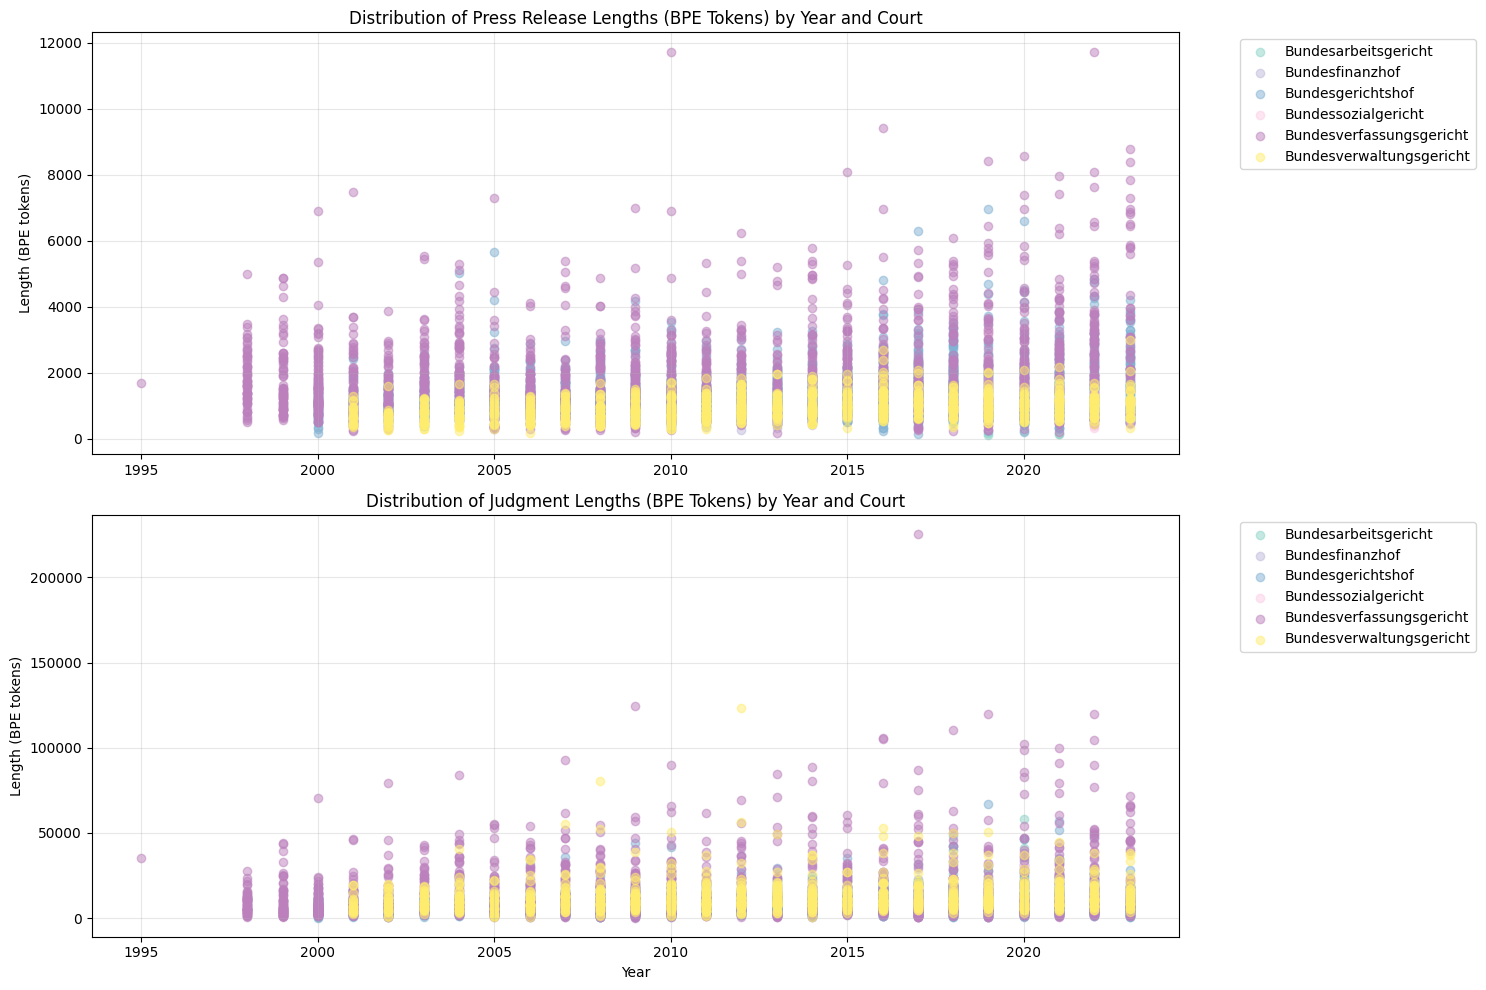

In [7]:
# Create scatter plots for summary and judgement lengths (in BPE tokens)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Get unique courts for color mapping
courts = df['subset_name'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(courts)))

# Plot summary lengths
for court, color in zip(courts, colors):
  mask = df['subset_name'] == court
  ax1.scatter(df[mask]['year'], df[mask]['summary_length'], 
        label=court, alpha=0.5, color=color)

ax1.set_title('Distribution of Press Release Lengths (BPE Tokens) by Year and Court')
ax1.set_ylabel('Length (BPE tokens)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot judgement lengths
for court, color in zip(courts, colors):
  mask = df['subset_name'] == court
  ax2.scatter(df[mask]['year'], df[mask]['judgement_length'], 
        label=court, alpha=0.5, color=color)

ax2.set_title('Distribution of Judgment Lengths (BPE Tokens) by Year and Court')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length (BPE tokens)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

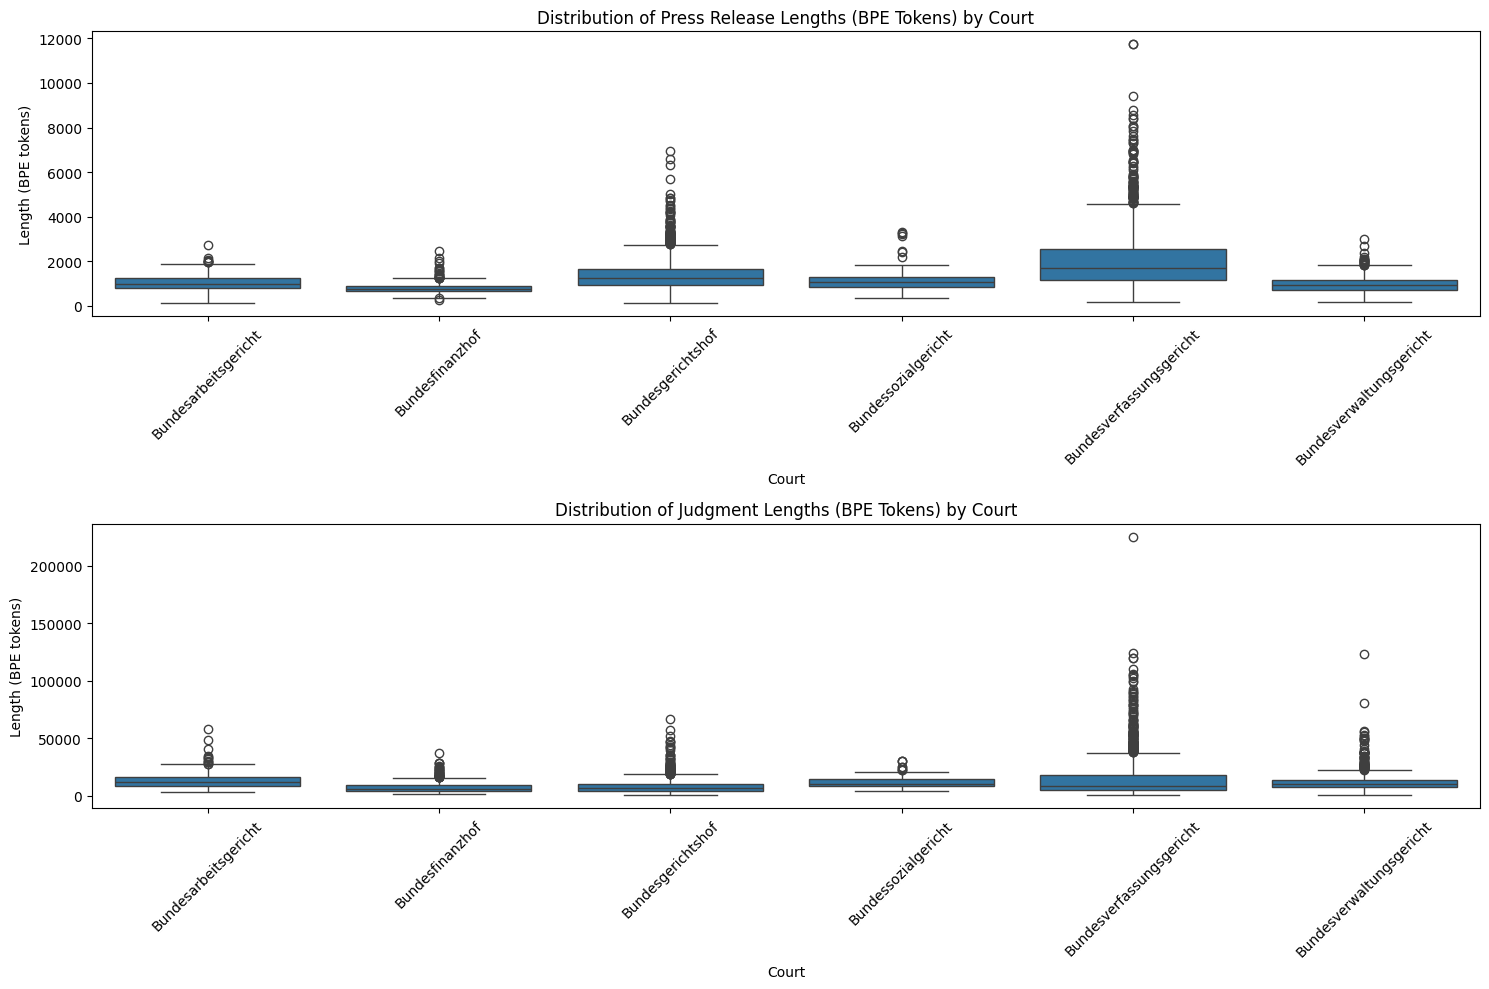


Average BPE Tokens per Court:
--------------------------------------------------
                          Summary Mean  Summary Std  Summary Count  \
subset_name                                                          
Bundesarbeitsgericht           1056.37       407.50            177   
Bundesfinanzhof                 800.28       213.58            761   
Bundesgerichtshof              1386.84       680.10           2407   
Bundessozialgericht            1146.66       484.69            161   
Bundesverfassungsgericht       2039.50      1353.63           1771   
Bundesverwaltungsgericht        942.91       336.86           1155   

                          Judgment Mean  Judgment Std  Judgment Count  
subset_name                                                            
Bundesarbeitsgericht           14148.00       7913.64             177  
Bundesfinanzhof                 7378.97       4410.79             761  
Bundesgerichtshof               8216.82       5686.26            2407

In [9]:
# Compare token length distributions between courts and calculate averages

import seaborn as sns



# Set up the figure for distribution plots

plt.figure(figsize=(15, 10))



# Create subplots for summary and judgment distributions

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))



# Plot distributions for summaries

sns.boxplot(data=df, x='subset_name', y='summary_length', ax=ax1)

ax1.set_title('Distribution of Press Release Lengths (BPE Tokens) by Court')

ax1.set_xlabel('Court')

ax1.set_ylabel('Length (BPE tokens)')

ax1.tick_params(axis='x', rotation=45)



# Plot distributions for judgments

sns.boxplot(data=df, x='subset_name', y='judgement_length', ax=ax2)

ax2.set_title('Distribution of Judgment Lengths (BPE Tokens) by Court')

ax2.set_xlabel('Court')

ax2.set_ylabel('Length (BPE tokens)')

ax2.tick_params(axis='x', rotation=45)



plt.tight_layout()

plt.show()



# Calculate and print average tokens per court

print('\nAverage BPE Tokens per Court:')

print('-' * 50)

court_stats = df.groupby('subset_name').agg({

    'summary_length': ['mean', 'std', 'count'],

    'judgement_length': ['mean', 'std', 'count']

}).round(2)



# Rename columns for better readability

court_stats.columns = ['Summary Mean', 'Summary Std', 'Summary Count',

                      'Judgment Mean', 'Judgment Std', 'Judgment Count']

print(court_stats)



# Calculate overall statistics

print('\nOverall Statistics:')

print('-' * 50)

print(f"Average Summary Length: {df['summary_length'].mean():.2f} ± {df['summary_length'].std():.2f} tokens")

print(f"Average Judgment Length: {df['judgement_length'].mean():.2f} ± {df['judgement_length'].std():.2f} tokens")